In [81]:
!pip install pdfplumber
!pip install seaborn

In [82]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns


import pandas as pd
import re
import pdfplumber

def extract_compound_summary(pdf_path):
    """
    Extract Compound Summary table from MassHunter Analysis Report PDF.
    
    Parameters:
    -----------
    pdf_path : str
        Path to the PDF file
        
    Returns:
    --------
    pd.DataFrame
        DataFrame containing the compound summary data
    """
    
    # Method 1: Using pdfplumber (recommended for tables)
    with pdfplumber.open(pdf_path) as pdf:
        compounds = []
        
        for page in pdf.pages:
            text = page.extract_text()
            
            # Find the Compound Summary section
            if "Compound Summary" in text:
                lines = text.split('\n')
                
                # Find where compound data starts
                start_idx = None
                for i, line in enumerate(lines):
                    if re.match(r'^\d+\s+C\d+\s+H\d+', line):
                        start_idx = i
                        break
                
                if start_idx:
                    # Parse each compound line
                    for line in lines[start_idx:]:
                        # Match pattern: number, formula, RT, Mass, optional CAS, Source, Scores
                        match = re.match(
                            r'^(\d+)\s+(C\d+\s+H\d+(?:\s+[A-Z][a-z]?\d*)*)\s+'
                            r'([\d.]+)\s+([\d.]+)\s+'
                            r'(?:([\d-]+)\s+)?'  # Optional CAS ID
                            r'(\w+)\s+([\d.]+)\s+(\w+)',
                            line
                        )
                        
                        if match:
                            cpd_num = int(match.group(1))
                            formula = match.group(2).replace(' ', '')
                            rt = float(match.group(3))
                            mass = float(match.group(4))
                            cas_id = match.group(5) if match.group(5) else None
                            source = match.group(6)
                            score = float(match.group(7))
                            algorithm = match.group(8)
                            
                            compounds.append({
                                'Cpd': cpd_num,
                                'Formula': formula,
                                'RT': rt,
                                'Mass': mass,
                                'CAS_ID': cas_id,
                                'Source': source,
                                'Score': score,
                                'Algorithm': algorithm
                            })
    
    return pd.DataFrame(compounds)


class CompoundAnalyzer:
    """
    Analyze compounds across multiple mass spec runs.
    """
    
    def __init__(self, dataframes_dict):
        """
        Parameters:
        -----------
        dataframes_dict : dict
            Dictionary with run names as keys and DataFrames as values
            Example: {'run1': df1, 'run2': df2, 'run3': df3, 'run4': df4}
        """
        self.runs = dataframes_dict
        self.run_names = list(dataframes_dict.keys())
        
    def get_top_compounds(self, n=500, sort_by='Score'):
        """
        Get top N compounds from each run.
        
        Parameters:
        -----------
        n : int
            Number of top compounds to extract
        sort_by : str
            Column to sort by ('Score', 'Mass', 'RT')
            
        Returns:
        --------
        dict : Top compounds for each run
        """
        top_compounds = {}
        
        for run_name, df in self.runs.items():
            # Sort and get top N
            sorted_df = df.sort_values(by=sort_by, ascending=False).head(n)
            top_compounds[run_name] = sorted_df
            print(f"{run_name}: {len(sorted_df)} compounds (top {n} by {sort_by})")
        
        return top_compounds
    
    def find_shared_compounds(self, top_n=10000, sort_by='Score', 
                             tolerance=0.001):
        """
        Find compounds that appear in multiple runs.
        
        Parameters:
        -----------
        top_n : int
            Consider top N compounds from each run
        sort_by : str
            How to rank compounds
        tolerance : float
            Mass tolerance for matching (in Da)
            
        Returns:
        --------
        pd.DataFrame : Shared compounds with occurrence counts
        """
        # Get top compounds from each run
        top_compounds = self.get_top_compounds(top_n, sort_by)
        
        # Combine all compounds with run information
        all_compounds = []
        
        for run_name, df in top_compounds.items():
            df_copy = df.copy()
            df_copy['Run'] = run_name
            all_compounds.append(df_copy)
        
        combined = pd.concat(all_compounds, ignore_index=True)
        
        # Group by formula (exact match)
        formula_groups = combined.groupby('Formula').agg({
            'Run': lambda x: list(x),
            'Mass': 'mean',
            'RT': 'mean',
            'Score': 'mean',
            'Cpd': 'count'
        }).reset_index()
        
        formula_groups.columns = ['Formula', 'Runs', 'Avg_Mass', 
                                  'Avg_RT', 'Avg_Score', 'Occurrence_Count']
        
        # Filter for compounds in 2+ runs
        shared = formula_groups[formula_groups['Occurrence_Count'] >= 2].copy()
        shared = shared.sort_values('Occurrence_Count', ascending=False)
        
        # Add which runs
        shared['Run_Names'] = shared['Runs'].apply(lambda x: ', '.join(x))
        shared['Num_Runs'] = shared['Runs'].apply(len)
        
        return shared
    
    def find_unique_compounds(self, top_n=10000, sort_by='Score'):
        """
        Find compounds unique to each run.
        
        Parameters:
        -----------
        top_n : int
            Consider top N compounds
        sort_by : str
            How to rank compounds
            
        Returns:
        --------
        dict : Unique compounds for each run
        """
        top_compounds = self.get_top_compounds(top_n, sort_by)
        
        # Collect all formulas from all runs
        all_formulas = {}
        for run_name, df in top_compounds.items():
            all_formulas[run_name] = set(df['Formula'])
        
        # Find unique formulas for each run
        unique_compounds = {}
        
        for run_name in self.run_names:
            # Get formulas from other runs
            other_formulas = set()
            for other_run in self.run_names:
                if other_run != run_name:
                    other_formulas.update(all_formulas[other_run])
            
            # Find formulas only in this run
            unique_formulas = all_formulas[run_name] - other_formulas
            
            # Get the actual compound data
            unique_df = top_compounds[run_name][
                top_compounds[run_name]['Formula'].isin(unique_formulas)
            ].copy()
            
            unique_df = unique_df.sort_values(sort_by, ascending=False)
            unique_compounds[run_name] = unique_df
            
            print(f"{run_name}: {len(unique_df)} unique compounds")
        
        return unique_compounds
    
    def get_top_unique(self, n=30, sort_by='Score'):
        """
        Get top N unique compounds per run.
        """
        unique = self.find_unique_compounds(top_n=10000, sort_by=sort_by)
        
        top_unique = {}
        for run_name, df in unique.items():
            top_unique[run_name] = df.head(n)
        
        return top_unique
    
    def generate_report(self, output_file='compound_analysis_report.txt'):
        """
        Generate a comprehensive report.
        """
        with open(output_file, 'w') as f:
            f.write("=" * 80 + "\n")
            f.write("COMPOUND ANALYSIS REPORT\n")
            f.write("=" * 80 + "\n\n")
            
            # Summary statistics
            f.write("DATASET SUMMARY\n")
            f.write("-" * 80 + "\n")
            for run_name, df in self.runs.items():
                f.write(f"{run_name}:\n")
                f.write(f"  Total compounds: {len(df)}\n")
                f.write(f"  Score range: {df['Score'].min():.2f} - {df['Score'].max():.2f}\n")
                f.write(f"  Mass range: {df['Mass'].min():.2f} - {df['Mass'].max():.2f}\n")
                f.write(f"  RT range: {df['RT'].min():.2f} - {df['RT'].max():.2f}\n\n")
            
            # Shared compounds
            f.write("\n" + "=" * 80 + "\n")
            f.write("SHARED COMPOUNDS (appearing in 2+ runs)\n")
            f.write("=" * 80 + "\n\n")
            
            shared = self.find_shared_compounds(top_n=10000)
            
            f.write(f"Total shared formulas: {len(shared)}\n\n")
            
            # Most frequently shared
            f.write("Top 20 Most Frequently Shared Compounds:\n")
            f.write("-" * 80 + "\n")
            for idx, row in shared.head(20).iterrows():
                f.write(f"\nFormula: {row['Formula']}\n")
                f.write(f"  Appears in {row['Num_Runs']} runs: {row['Run_Names']}\n")
                f.write(f"  Avg Mass: {row['Avg_Mass']:.4f}\n")
                f.write(f"  Avg Score: {row['Avg_Score']:.2f}\n")
            
            # Unique compounds
            f.write("\n\n" + "=" * 80 + "\n")
            f.write("TOP UNIQUE COMPOUNDS PER RUN\n")
            f.write("=" * 80 + "\n\n")
            
            top_unique = self.get_top_unique(n=20)
            
            for run_name, df in top_unique.items():
                f.write(f"\n{run_name} - Top 20 Unique Compounds:\n")
                f.write("-" * 80 + "\n")
                for idx, row in df.iterrows():
                    f.write(f"{row['Cpd']:3d}. {row['Formula']:20s} "
                           f"Mass: {row['Mass']:8.4f}  Score: {row['Score']:5.2f}  "
                           f"RT: {row['RT']:6.3f}\n")
        
        print(f"\nReport saved to {output_file}")
    
    def visualize_overlap(self):
        """
        Create visualizations of compound overlap.
        """
        # Get shared compounds
        shared = self.find_shared_compounds(top_n=10000)
        
        # Plot 1: Distribution of shared compounds
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Occurrence distribution
        ax1 = axes[0, 0]
        occurrence_counts = shared['Num_Runs'].value_counts().sort_index()
        ax1.bar(occurrence_counts.index, occurrence_counts.values, color='steelblue')
        ax1.set_xlabel('Number of Runs')
        ax1.set_ylabel('Number of Compounds')
        ax1.set_title('Distribution of Shared Compounds')
        ax1.set_xticks(range(2, len(self.runs) + 1))
        
        # Unique compounds per run
        ax2 = axes[0, 1]
        unique = self.find_unique_compounds(top_n=10000)
        unique_counts = {run: len(df) for run, df in unique.items()}
        ax2.bar(unique_counts.keys(), unique_counts.values(), color='coral')
        ax2.set_xlabel('Run')
        ax2.set_ylabel('Number of Unique Compounds')
        ax2.set_title('Unique Compounds per Run')
        ax2.tick_params(axis='x', rotation=45)
        
        # Mass distribution comparison
        ax3 = axes[1, 0]
        for run_name, df in self.runs.items():
            ax3.hist(df['Mass'], bins=50, alpha=0.5, label=run_name)
        ax3.set_xlabel('Mass (Da)')
        ax3.set_ylabel('Count')
        ax3.set_title('Mass Distribution Across Runs')
        ax3.legend()
        
        # Score distribution comparison
        ax4 = axes[1, 1]
        for run_name, df in self.runs.items():
            ax4.hist(df['Score'], bins=30, alpha=0.5, label=run_name)
        ax4.set_xlabel('Score')
        ax4.set_ylabel('Count')
        ax4.set_title('Score Distribution Across Runs')
        ax4.legend()
        
        plt.tight_layout()
        plt.savefig('compound_analysis.png', dpi=300, bbox_inches='tight')
        print("Visualization saved to compound_analysis.png")
        plt.show()



In [83]:
runs_dict = {
    'bigmed': extract_compound_summary('MS_RESULTS/BIGMED_shell_Analysis.pdf'),
    'large': extract_compound_summary('MS_RESULTS/LARGE_shell_Analysis.pdf'),
    'med': extract_compound_summary('MS_RESULTS/MED_shell_Analysis.pdf'),
    'tiny': extract_compound_summary('MS_RESULTS/TINY_shell_Analysis.pdf'),
}


FINDING SHARED COMPOUNDS
bigmed: 4771 compounds (top 10000 by Score)
large: 5266 compounds (top 10000 by Score)
med: 8346 compounds (top 10000 by Score)
tiny: 7752 compounds (top 10000 by Score)

Found 6775 formulas appearing in 2+ runs

Most frequently shared compounds:
            Formula  Num_Runs  \
15289    C9H17N3O5S        13   
6012       C35H52O4         9   
7376       C40H64O6         8   
4295      C28H57O7P         8   
6092       C35H58O5         8   
10179        C4H6O2         8   
856         C15H22O         8   
5917      C34H65NO2         8   
12973  C62H122NO10P         7   
2928       C24H36O5         7   

                                               Run_Names  Avg_Score  
15289  large, large, large, large, large, large, larg...  74.270769  
6012   bigmed, large, large, large, large, large, lar...  85.707778  
7376   bigmed, large, large, large, large, large, med...  74.047500  
4295   bigmed, large, large, large, large, large, med...  72.431250  
6092   bigmed

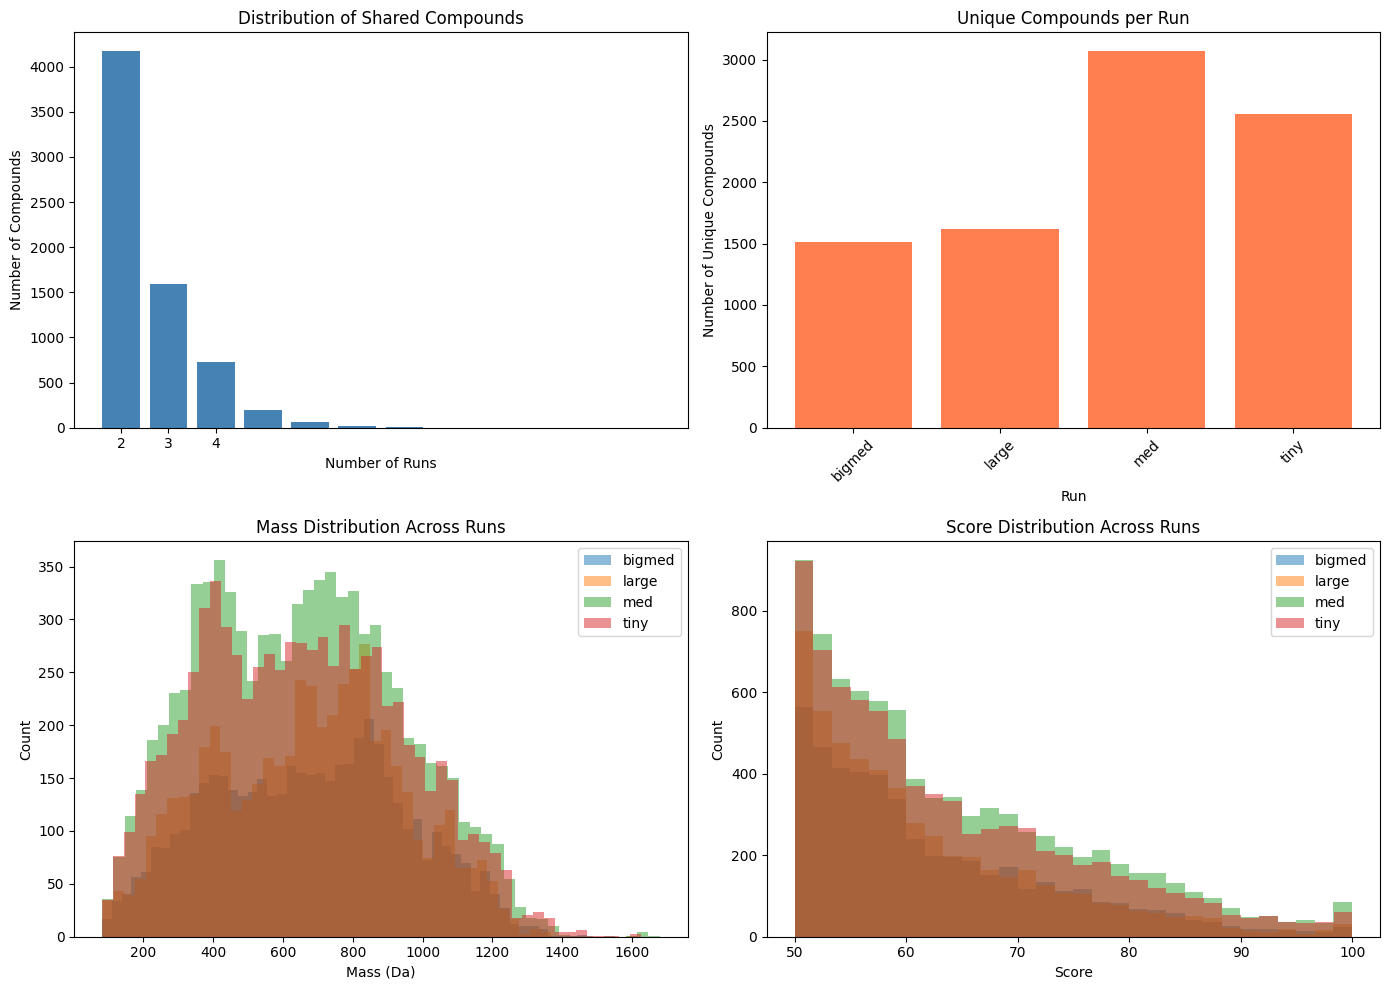

In [84]:
# Load your dataframes
# Assuming you have 4 dataframes: df1, df2, df3, df4

# Example with dummy data - replace with your actual dataframes


# Create analyzer
analyzer = CompoundAnalyzer(runs_dict)

# Find shared compounds (top 500 by Score)
print("\n" + "="*60)
print("FINDING SHARED COMPOUNDS")
print("="*60)
shared_compounds = analyzer.find_shared_compounds(top_n=10000, sort_by='Score')

print(f"\nFound {len(shared_compounds)} formulas appearing in 2+ runs")
print("\nMost frequently shared compounds:")
print(shared_compounds[['Formula', 'Num_Runs', 'Run_Names', 'Avg_Score']].head(10))

# Find unique compounds
print("\n" + "="*60)
print("FINDING UNIQUE COMPOUNDS")
print("="*60)
unique_compounds = analyzer.find_unique_compounds(top_n=10000, sort_by='Score')

# Get top 20 unique per run
print("\n" + "="*60)
print("TOP 10-20 UNIQUE COMPOUNDS PER RUN")
print("="*60)
top_unique = analyzer.get_top_unique(n=30, sort_by='Score')

for run_name, df in top_unique.items():
    print(f"\n{run_name}: Top 10 unique compounds")
    print(df[['Cpd', 'Formula', 'Mass', 'Score', 'RT']].head(10))

# Generate full report
analyzer.generate_report('compound_analysis_report.txt')

# Create visualizations
analyzer.visualize_overlap()

# Save results to CSV
shared_compounds.to_csv('shared_compounds.csv', index=False)
for run_name, df in top_unique.items():
    df.to_csv(f'{run_name}_unique_top20.csv', index=False)

In [85]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [86]:
top_unique

{'bigmed':        Cpd       Formula      RT       Mass CAS_ID Source  Score Algorithm
 3598  3601   C16H19N3O5S   4.749   365.1046   None    FBF  91.56       FBF
 1635  1637   C64H117NO10  20.107  1059.8758   None    FBF  91.27       FBF
 1858  1860     C31H55NO7   5.399   553.3978   None    FBF  90.28       FBF
 3184  3186   C31H48NO13P  13.611   673.2838   None    FBF  89.78       FBF
 3632  3635      C7H11N5O   3.763   181.0965   None    FBF  86.70       FBF
 3460  3462  C12H23N3O5S2  10.284   353.1085   None    FBF  86.64       FBF
 1352  1354   C66H108O12S  18.885  1124.7582   None    FBF  86.63       FBF
 19      20   C16H18FN3O3   0.647   319.1314   None    FBF  86.22       FBF
 2234  2236    C27H47O10P   4.749   562.2907   None    FBF  86.09       FBF
 1442  1444     C35H59NO8  19.093   621.4269   None    FBF  85.50       FBF
 3590  3593       C10H6O4   0.933   190.0273   None    FBF  84.73       FBF
 1734  1736     C39H66O12  19.015   726.4574   None    FBF  84.01       FBF
 3

In [89]:
top_unique['bigmed']

,Cpd,Formula,RT,Mass,CAS_ID,Source,Score,Algorithm
3598,3601,C16H19N3O5S,4.749,365.1046,None,FBF,91.56,FBF
1635,1637,C64H117NO10,20.107,1059.8758,None,FBF,91.27,FBF
1858,1860,C31H55NO7,5.399,553.3978,None,FBF,90.28,FBF
3184,3186,C31H48NO13P,13.611,673.2838,None,FBF,89.78,FBF
3632,3635,C7H11N5O,3.763,181.0965,None,FBF,86.70,FBF
3460,3462,C12H23N3O5S2,10.284,353.1085,None,FBF,86.64,FBF
1352,1354,C66H108O12S,18.885,1124.7582,None,FBF,86.63,FBF
19,20,C16H18FN3O3,0.647,319.1314,None,FBF,86.22,FBF
2234,2236,C27H47O10P,4.749,562.2907,None,FBF,86.09,FBF
1442,1444,C35H59NO8,19.093,621.4269,None,FBF,85.50,FBF


In [ ]:
import requests 
import pubchempy as pcp

def find_with_pubchempy(formula):
    print('loooking formula ', formula)
    try:
        compounds = pcp.get_compounds(formula, "formula",listkey_count=5)
        names = [compound.to_dict()['iupac_name']for compound in compounds] 
        print('names', names)
        return names
    except Exception as e:
        print('we have hit the exception: ', e)
        return []
    




In [110]:
# Stitch the dictionary of DataFrames into one big DataFrame
combined_df = pd.DataFrame()
for key, df in top_unique.items():
    df['Source_Key'] = key
    combined_df = pd.concat([combined_df, df])
combined_df = combined_df.reset_index(drop=False) # Keep the original 'Cpd' as a column
combined_df


,index,Cpd,Formula,RT,Mass,CAS_ID,Source,Score,Algorithm,Source_Key
0,3598,3601,C16H19N3O5S,4.749,365.1046,None,FBF,91.56,FBF,bigmed
1,1635,1637,C64H117NO10,20.107,1059.8758,None,FBF,91.27,FBF,bigmed
2,1858,1860,C31H55NO7,5.399,553.3978,None,FBF,90.28,FBF,bigmed
3,3184,3186,C31H48NO13P,13.611,673.2838,None,FBF,89.78,FBF,bigmed
4,3632,3635,C7H11N5O,3.763,181.0965,None,FBF,86.70,FBF,bigmed
...,...,...,...,...,...,...,...,...,...,...
115,3748,3751,C32H56NO8P,5.322,613.3758,None,FBF,83.47,FBF,tiny
116,1058,1061,C4H12N2,21.148,88.1007,None,FBF,83.17,FBF,tiny
117,647,650,C5H6O2,0.409,98.0363,None,FBF,83.16,FBF,tiny
118,6180,6187,C38H73NO5,18.291,623.5478,None,FBF,82.84,FBF,tiny


In [119]:
from tqdm import tqdm
import pandas as pd

# If you haven't already, wrap pandas apply with tqdm
tqdm.pandas()

# Example with your combined_df
combined_df['Common_names'] = combined_df['Formula'].progress_apply(lambda x: find_with_pubchempy(x))

# Save to CSV
combined_df.to_csv('top_unique_with_compound_names.csv', index=False)


  0%|          | 0/120 [00:00<?, ?it/s]

loooking formula  C16H19N3O5S


  2%|▏         | 2/120 [00:03<03:32,  1.80s/it]

names ['(2S,5R,6R)-6-[[(2R)-2-amino-2-(4-hydroxyphenyl)acetyl]amino]-3,3-dimethyl-7-oxo-4-thia-1-azabicyclo[3.2.0]heptane-2-carboxylic acid', '(6R,7R)-7-[[(2R)-2-amino-2-cyclohexa-1,4-dien-1-ylacetyl]amino]-3-methoxy-8-oxo-5-thia-1-azabicyclo[4.2.0]oct-2-ene-2-carboxylic acid', '(6R,7R)-7-[[(2R)-2-amino-2-phenylacetyl]amino]-3-methyl-8-oxo-5-thia-1-azabicyclo[4.2.0]oct-2-ene-2-carboxylic acid;hydrate', '3-[[4-(diethylamino)-2-hydroxyphenyl]diazenyl]-4-hydroxybenzenesulfonic acid', '(2S,5R,6R)-6-[[(2S)-2-amino-2-(4-hydroxyphenyl)acetyl]amino]-3,3-dimethyl-7-oxo-4-thia-1-azabicyclo[3.2.0]heptane-2-carboxylic acid']
loooking formula  C64H117NO10


  2%|▎         | 3/120 [00:07<04:56,  2.54s/it]

names ['[4,5-dihydroxy-2-[(E)-3-hydroxy-2-[[(13Z,16Z)-2-hydroxydocosa-13,16-dienoyl]amino]hexadec-4-enoxy]-6-(hydroxymethyl)oxan-3-yl] (E)-icos-11-enoate', '[4,5-dihydroxy-2-[(E)-3-hydroxy-2-(2-hydroxytetradecanoylamino)octadec-4-enoxy]-6-(hydroxymethyl)oxan-3-yl] (14Z,17Z,20Z)-hexacosa-14,17,20-trienoate', '[4,5-dihydroxy-2-[(E)-3-hydroxy-2-[[(14Z,17Z,20Z)-2-hydroxyhexacosa-14,17,20-trienoyl]amino]hexadec-4-enoxy]-6-(hydroxymethyl)oxan-3-yl] hexadecanoate', '[4,5-dihydroxy-2-[(E)-3-hydroxy-2-[[(8Z,11Z,14Z)-2-hydroxyicosa-8,11,14-trienoyl]amino]octadec-4-enoxy]-6-(hydroxymethyl)oxan-3-yl] icosanoate', '(15Z,18Z)-N-[(8E,12E,16E)-3,4-dihydroxy-1-[3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxyoctacosa-8,12,16-trien-2-yl]-2-hydroxytriaconta-15,18-dienamide']
loooking formula  C31H55NO7


  3%|▎         | 4/120 [00:10<05:39,  2.92s/it]

names ['(3R,5R)-7-[(1S,2S,6S,8S,8aR)-6-hydroxy-2-methyl-8-[(2S)-2-methylbutanoyl]oxy-1,2,6,7,8,8a-hexahydronaphthalen-1-yl]-3,5-dihydroxyheptanoic acid;2,4,4-trimethylpentan-2-amine', '4-[3-butanoyloxy-2-[(9Z,12Z)-heptadeca-9,12-dienoyl]oxypropoxy]-2-(trimethylazaniumyl)butanoate', '4-[2-[(9Z,12Z)-octadeca-9,12-dienoyl]oxy-3-propanoyloxypropoxy]-2-(trimethylazaniumyl)butanoate', '4-[2-[(9Z,12Z)-hexadeca-9,12-dienoyl]oxy-3-pentanoyloxypropoxy]-2-(trimethylazaniumyl)butanoate', '4-[3-acetyloxy-2-[(9Z,12Z)-nonadeca-9,12-dienoyl]oxypropoxy]-2-(trimethylazaniumyl)butanoate']
loooking formula  C31H48NO13P


  3%|▎         | 4/120 [00:14<06:48,  3.52s/it]


ServerError: 'PUGREST.ServerError: GetEntrezKey fault: Server, message: NCBI C++ Exception:'

In [92]:
import os
import pandas as pd
import requests

# 🔑 Replace with your ChemSpider API key
API_KEY = "qhWnb1GJnY2mDflnKuFUl2VtghHEElig8CP3nPP3"
BASE_URL = "https://api.rsc.org/compounds/v1"
HEADERS = {"apikey": API_KEY, "Content-Type": "application/json"}

In [112]:
import requests 
import pubchempy as pcp

def find_with_pubchempy(formula):
    compounds = pcp.get_compounds(formula, "formula")
    names = [compound.to_dict()['iupac_name']for compound in compounds] 
    return names


def find_with_chemspider(formula, top_n=6):
    url = "https://api.rsc.org/compounds/v1/filter/formula" 
    payload = { "formula": formula,
                "orderBy": "default",
                "orderDirection": "default" }
    headers = { "apikey": API_KEY,
                "Content-Type": "application/json",
                "Accept": "application/json" }
    response = requests.post(url, json=payload, headers=headers)
    print(response.json())


    
    url = f"https://api.rsc.org/compounds/v1/filter/{response.json()['queryId']}/results"

    headers = { "apikey": API_KEY,
                "Accept": "application/json" }

    response = requests.get(url, headers=headers)
    print(response.json())
    response.json()
    names = []
    for result in response.json()['results'][:top_n]:
        url = f"https://api.rsc.org/compounds/v1/records/{result}/details?fields=CommonName" 

        headers = { "apikey": API_KEY,
                    "Accept": "application/json" }

        response = requests.get(url, headers=headers)
        print(response.json())
        names.append(response.json()['commonName'])
    return names
